In [1]:
### plot daily mean CS2_CPOM and SM-LG snow depth for FYI and MYI for each season

In [ ]:
import numpy as np
from scipy.stats import pearsonr
import datetime
import pandas as pd
from scipy.stats import linregress
from netCDF4 import Dataset
from scipy.interpolate import griddata
import os
import pickle
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import cartopy
import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
# load all prep 

# 1 Oct - 30 Apr
seasonal_days = [np.arange(273,484), # 2010-2011
        np.arange(638,850), # 2011-2012
        np.arange(1004,1215), # 2012-2013
        np.arange(1369,1580), # 2013-2014
        np.arange(1734,1945), # 2014-2015
        np.arange(2099,2311), # 2015-2016
        np.arange(2464,2676), # 2016-2017
        np.arange(2830,3041), # 2017-2018
        np.arange(3194,3406), # 2018-2019
        np.arange(3560,3772) # 2019-2020
       ]

# 1 Dec - 1 Apr
# seasonal_days = [np.arange(334,455), # 2010-2011
#         np.arange(699,821), # 2011-2012
#         np.arange(1065,1186), # 2012-2013
#         np.arange(1430,1551), # 2013-2014
#         np.arange(1795,1916), # 2014-2015
#         np.arange(2160,2282), # 2015-2016
#         np.arange(2526,2647), # 2016-2017
#         np.arange(2891,3012), # 2017-2018
#         np.arange(3256,3377), # 2018-2019
#         np.arange(3621,3743) # 2019-2020
#        ]

seasons = ['2010-2011','2011-2012','2012-2013','2013-2014','2014-2015','2015-2016','2016-2017','2017-2018','2018-2019',
          '2019-2020']

days = np.arange(0,4018)
dates = [datetime.date(2010,1,1)+datetime.timedelta(days=np.int(days)) for days in days]

x_WG = np.load('/Users/carmennab/PhD/OI_PolarSnow/SnowModelLG/new_x_WG.npy') # load Will's grid, 160 x 160 array
y_WG = np.load('/Users/carmennab/PhD/OI_PolarSnow/SnowModelLG/new_y_WG.npy')

snow = np.load('/Users/carmennab/PhD/OI_PolarSnow/SnowModelLG/SM_snod_combined_regridded.npy')

# import CS2_CPOM data
datapath = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_interpolated/CS2_CPOM/'
all_fbs_cpom = np.full((4018,160,160), np.nan)
for day in tqdm.tqdm(days):
    date = dates[day].strftime('%Y%m%d')
    for f in os.listdir(datapath):
        if 'FB_interp' in f:
            if date in f:
                all_fbs_cpom[day] = np.load(datapath+str(f))
            else: 
                pass

100%|██████████████████████████████████████| 4018/4018 [00:16<00:00, 248.59it/s]


In [3]:
all_snow_FYI = {}
all_snow_MYI = {}
all_fb_FYI = {}
all_fb_MYI = {}

for season, days in zip(seasons,seasonal_days):
    dayss = np.arange(0,len(days))
    fb = all_fbs_cpom[days]
    sm = snow[days]
          
    icetype_grid = np.load('/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/icetype/icetype_Oct'+season.split('-')[0]+'_Apr'+season.split('-')[1]+'_'+season+'.npy')

    #get grid cells which have been either FYI or MYI for the whole season
    FYI_row = [] ; MYI_row = []
    FYI_col = [] ; MYI_col = []
    for i in range(160):
        for j in range(160):
            if (icetype_grid[i,j,:] == 2).all():
                FYI_row.append(i) ; FYI_col.append(j)
            elif (icetype_grid[i,j,:] == 3).all():
                MYI_row.append(i) ; MYI_col.append(j)                
    FYI = (FYI_row,FYI_col)
    MYI = (MYI_row,MYI_col)

    zones = [FYI,MYI]
    
    snow_FYI = np.full((len(days),160,160),np.nan)
    snow_MYI = np.full((len(days),160,160),np.nan)
    snow_mean_FYI = np.full(len(days),np.nan)
    snow_mean_MYI = np.full(len(days),np.nan)
    
        
    fb_FYI = np.full((len(days),160,160),np.nan)
    fb_MYI = np.full((len(days),160,160),np.nan)
    fb_mean_FYI = np.full(len(days),np.nan)
    fb_mean_MYI = np.full(len(days),np.nan)
    
    for day in dayss:
        snowz=sm[day]
        fbz = fb[day]

        #FYI
        a = snowz[FYI]
        snow_mean_FYI[day] = np.nanmean(a) * 100
        b = fbz[FYI]
        fb_mean_FYI[day] = np.nanmean(b) * 100

        #MYI
        a = snowz[MYI]
        snow_mean_MYI[day] = np.nanmean(a) * 100
        b = fbz[MYI]
        fb_mean_MYI[day] = np.nanmean(b) * 100
    
    all_snow_FYI[season] = snow_mean_FYI
    all_fb_FYI[season] = fb_mean_FYI
    all_snow_MYI[season] = snow_mean_MYI
    all_fb_MYI[season] = fb_mean_MYI
    

In [4]:
obs_snow = []
obs_fb = []
labels = []
for season in seasons:
    obs_snow.append(all_snow_FYI[season])
    obs_snow.append(all_snow_MYI[season])
    labels.append('FYI')
    obs_fb.append(all_fb_FYI[season])
    obs_fb.append(all_fb_MYI[season])
    labels.append('MYI')

<Figure size 432x288 with 0 Axes>

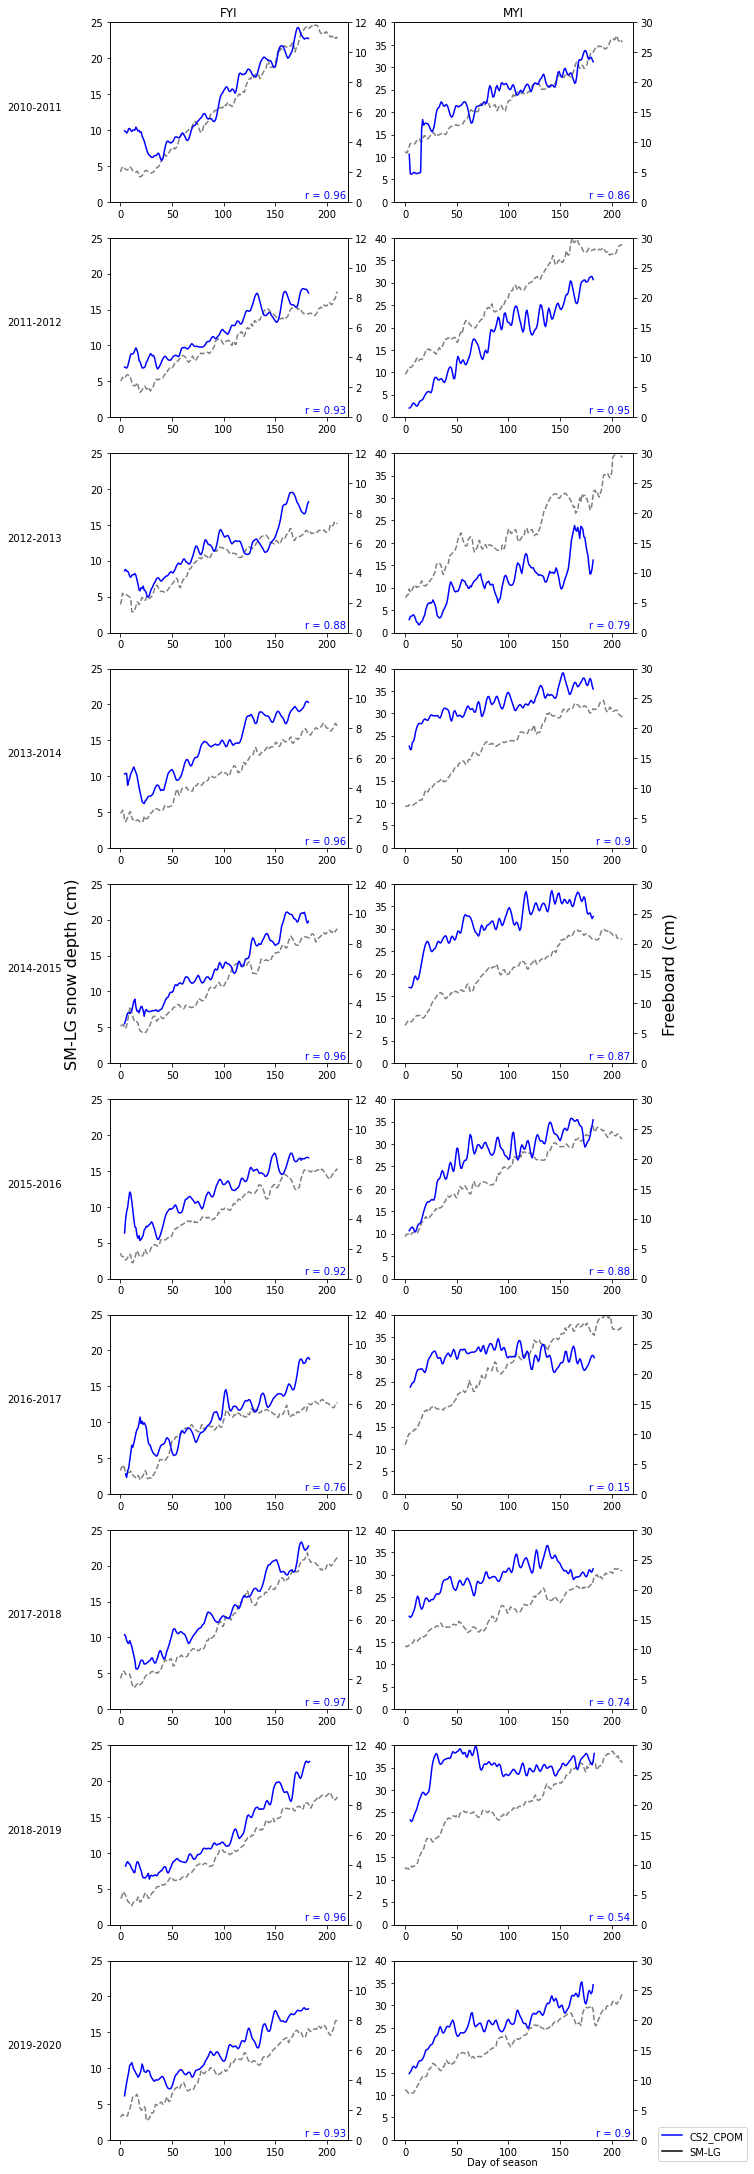

In [5]:
plt.figure()
fig, axs = plt.subplots(10,2,figsize=(8,30))
fig.tight_layout(w_pad=1.5,h_pad=1.5)

new_seasons = []
for i in seasons:
    new_seasons.append(i)
    new_seasons.append(i)

new_seasonal_days = []
for i in seasonal_days:
    new_seasonal_days.append(i)
    new_seasonal_days.append(i)

for counter, ax in enumerate(axs.reshape(-1)):
    fb = obs_fb[counter]
    snow = obs_snow[counter]
    season = new_seasons[counter]
    days = np.arange(0,len(new_seasonal_days[counter]))
    
    mask = ~np.isnan(fb) & ~np.isnan(snow)
    rstats = pearsonr(fb[mask],snow[mask])
    r = np.round(rstats[0],decimals=2)
    
    ax.plot(days[:211],snow[:211],'k',linestyle='--',linewidth=1.5,alpha=0.5)    
    if counter in [0,2,4,6,8,10,12,14,16,18]:
        ax.set_ylim(0,25)
        ax.annotate(season,xy=(-0.2,0.5),va='bottom',ha='right',xycoords='axes fraction',color='k')
    else:
        ax.set_ylim(0,40)
    if counter == 8:
        ax.set_ylabel('SM-LG snow depth (cm)',labelpad=10,fontsize=16)


    axb = ax.twinx()
    axb.plot(days[:211], fb[:211], label ='CS2_CPOM',color='blue')
    axb.plot(days[0],[0], label ='SM-LG',color='k')
    axb.annotate(f'r = {r}',xy=(0.99,0.01),va='bottom',ha='right',xycoords='axes fraction',color='blue') 
    if counter == 0:
        axb.set_title('FYI')
    if counter == 1:
        axb.set_title('MYI')
    if counter == 9:
        axb.set_ylabel('Freeboard (cm)',labelpad=10,fontsize=16)
    if counter in [0,2,4,6,8,10,12,14,16,18]:
        axb.set_ylim(0,12)
    else:
        axb.set_ylim(0,30)
    if counter == 19:
        axb.annotate('Day of season',xy=(0.6,-0.15),va='bottom',ha='right',xycoords='axes fraction',color='k') 

axb.legend(bbox_to_anchor = (1.5, 0.1))
plt.savefig('/Users/carmennab/Dropbox/Apps/Overleaf/AGU GRL Snow Interpolated Freeboards/figures/FYI_MYI_seasonal_timeseries.png',bbox_inches = "tight")